In [1]:
from __future__ import print_function, division
import functools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import functools
from typing import Union
import argparse
import shutil
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.functional as F
from tensorboardX import SummaryWriter

In [2]:
#standard resnet18 training

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/roshanrajan/Desktop/oxford-102-flowers'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

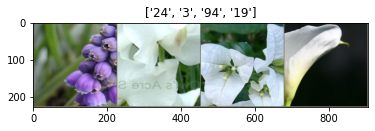

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7708 Acc: 0.8608
val Loss: 0.4004 Acc: 0.8931

Epoch 1/24
----------
train Loss: 0.7325 Acc: 0.8618
val Loss: 0.4117 Acc: 0.8961

Epoch 2/24
----------
train Loss: 0.6810 Acc: 0.8853
val Loss: 0.3699 Acc: 0.9010

Epoch 3/24
----------


In [8]:
#discriminative lr

In [9]:
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import torchvision
import functools
import torch
from typing import Union

'''
Developped by the Fastai team for the Fastai library
From the fastai library
https://www.fast.ai and https://github.com/fastai/fastai
'''

###############################################################################
#Unmodified classes and functions:

class PrePostInitMeta(type):
    "A metaclass that calls optional `__pre_init__` and `__post_init__` methods"
    def __new__(cls, name, bases, dct):
        x = super().__new__(cls, name, bases, dct)
        old_init = x.__init__
        def _pass(self): pass
        @functools.wraps(old_init)
        def _init(self,*args,**kwargs):
            self.__pre_init__()
            old_init(self, *args,**kwargs)
            self.__post_init__()
        x.__init__ = _init
        if not hasattr(x,'__pre_init__'):  x.__pre_init__  = _pass
        if not hasattr(x,'__post_init__'): x.__post_init__ = _pass
        return x

class Module(nn.Module, metaclass=PrePostInitMeta):
    "Same as `nn.Module`, but no need for subclasses to call `super().__init__`"
    def __pre_init__(self): super().__init__()
    def __init__(self): pass

class ParameterModule(Module):
    "Register a lone parameter `p` in a module."
    def __init__(self, p:nn.Parameter): self.val = p
    def forward(self, x): return x

def children(m:nn.Module):
    "Get children of `m`."
    return list(m.children())

def num_children(m:nn.Module):
    "Get number of children modules in `m`."
    return len(children(m))

def children_and_parameters(m:nn.Module):
    "Return the children of `m` and its direct parameters not registered in modules."
    children = list(m.children())
    children_p = sum([[id(p) for p in c.parameters()] for c in m.children()],[])
    for p in m.parameters():
        if id(p) not in children_p: children.append(ParameterModule(p))
    return children

def even_mults(start:float, stop:float, n:int)->np.ndarray:
    "Build log-stepped array from `start` to `stop` in `n` steps."
    mult = stop/start
    step = mult**(1/(n-1))
    return np.array([start*(step**i) for i in range(n)])

flatten_model = lambda m: sum(map(flatten_model,children_and_parameters(m)),[]) if num_children(m) else [m]
###############################################################################

'''
Modified version of lr_range from fastai
https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L185
'''
def lr_range(net:nn.Module, lr:slice, model_len:int)->np.ndarray:
        "Build differential learning rates from `lr`."

        if not isinstance(lr,slice): return lr
        if lr.start: res = even_mults(lr.start, lr.stop, model_len)
        else: res = [lr.stop/10]*(model_len-1) + [lr.stop]
        return res

def unfreeze_layers(model:nn.Sequential, unfreeze:bool=True)->None:
    "Unfreeze or freeze all layers"

    for layer in model.parameters():
        layer.requires_grad = unfreeze

def build_param_dicts(layers:nn.Sequential, lr:list=[0], return_len:bool=False)->Union[int,list]:
    '''
    Either return the number of layers with requires_grad is True
    or return a list of dictionnaries containing each layers on its associated LR"
    Both weight and bias are check for requires_grad is True
    '''

    params = []
    idx = 0
    for layer in layers:
        param = []
        if (hasattr(layer, "requires_grad") and layer.requires_grad):
            #To implement for custom nn.Parameter()
            print("Custom nn.Parameter() not supported")
        if(hasattr(layer, "weight") and layer.weight.requires_grad):
            param.append(layer.weight)
        if (hasattr(layer, "bias") and hasattr(layer.bias, "requires_grad") and layer.bias.requires_grad):
            param.append(layer.bias)
        if param: params.append({'params': param, 'lr': f'{lr[idx]}'}); idx += 1
        if return_len: idx = 0 #We don't want to increment idx here.

    return len(params) if return_len else params

def discriminative_lr_params(net:nn.Module, lr:slice, unfreeze:bool=True)->Union[list,np.ndarray,nn.Sequential]:
    '''
    Flatten our model and generate a list of dictionnaries to be passed to the
    optimizer.
    - If only one learning rate is passed as a slice the last layer will have the
    corresponding learning rate and all other ones will have lr/10
    - If two learning rates are passed such as slice(min_lr, max_lr) the last
    layer will have max_lr as a learning rate and the first one will have min_lr.
    All middle layers will have learning rates logarithmically interpolated
    ranging from min_lr to max_lr
    '''

    layers = nn.Sequential(*flatten_model(net)) #Flatten/ungroup our model
    if unfreeze: unfreeze_layers(layers, True)  #Unfreeze all layers

    #Return the number of layer where requires_grad is True (bias + weight)
    model_len = build_param_dicts(layers, return_len=True)

    #Create the list of learning rates
    list_lr = lr_range(net, lr, model_len)

    #Create our optimizer parameters list of dictionnaries
    params_layers = build_param_dicts(layers, list_lr)

    return params_layers, np.array(list_lr), layers

In [ ]:
model_disc_lr = models.resnet18(pretrained=True)

params, lr_arr, _ = discriminative_lr_params(model_disc_lr, slice(1e-5, 1e-3))

model_disc = model_disc_lr.to(device)

optim = torch.optim.SGD(params, lr=1e-3, momentum=0.9, weight_decay=1e-1)

lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optim, base_lr=list(lr_arr), max_lr=list(lr_arr*100))

In [ ]:
model_disc_lr.train_model(model_disc, criterion, optim, lr_scheduler, num_epochs=25)